In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time
from gprofiler import GProfiler

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
df_hom = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'
                     'mouse_human_homologs.txt', sep='\t')
dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
GS_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gs_file/gwas_max_abs_z.top500.gs'
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/results/fig_tcell'

# Data set info
DS_LIST = ['facs', 'canogamez']
# DS_LIST = ['facs', 'droplet', 'canogamez']
DIC_INFO = {}
DIC_INFO['facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}
DIC_INFO['droplet'] = {'species': 'mmusculus', 'dname': 'TMS Droplet'}
DIC_INFO['canogamez'] = {'species': 'hsapiens', 'dname': 'Human CD4 T cells'}

# Set score files
DIC_SCORE_PATH = {'facs': DATA_PATH+'/score_file/score.tms_facs_with_cov.gwas_max_abs_z.top500',
                  'droplet': DATA_PATH+'/score_file/score.tms_droplet_with_cov.gwas_max_abs_z.top500',
                  'canogamez': DATA_PATH+'/score_file/score.canogamez_with_cov.gwas_max_abs_z.top500',
                  'facs_tsig': DATA_PATH+'/score_file/score.tms_facs_with_cov.tcell_sig',
                  'droplet_tsig': DATA_PATH+'/score_file/score.tms_droplet_with_cov.tcell_sig'}

TRAIT_LIST = ['PASS_IBD', 
              'PASS_Rheumatoid_Arthritis', 
              'PASS_AdultOnsetAsthma_Ferreira2019', 
              'UKB_460K.disease_AID_ALL', 
              'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED', 
              'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP']

DIC_TRAIT_NAME = {'PASS_IBD': 'IBD', 'PASS_IBD_deLange2017': 'IBD_deLange2017', 'PASS_Multiple_sclerosis': 'MS',
                  'PASS_Rheumatoid_Arthritis': 'RA', 'PASS_AdultOnsetAsthma_Ferreira2019':'ASTHMA_Ferreira2019', 
                  'UKB_460K.disease_ASTHMA_DIAGNOSED':'ASTHMA', 'UKB_460K.blood_LYMPHOCYTE_COUNT':'LYMPH_COUNT',
                  'UKB_460K.disease_AID_ALL':'AID', 'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED':'ECZEMA',
                  'UKB_460K.disease_DERMATOLOGY':'DERMATOLOGY', 
                  'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP':'HT', 
                  'UKB_460K.disease_RESPIRATORY_ENT':'RESPIRATORY_ENT'}

In [3]:
# Load raw data 
dic_data_raw = {}
dic_data_raw['facs'] = dl.load_tms_ct(DATA_PATH, data_name='facs')
# dic_data_raw['droplet'] = dl.load_tms_ct(DATA_PATH, data_name='droplet')
dic_data_raw['canogamez'] = dl.load_canogamez_raw_data()

dic_data_proc = {}
dic_data_proc['facs'] = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/tms_proc/'
                                  'tcell.facs.annot.h5ad')
dic_data_proc['canogamez'] = dl.load_canogamez_raw_data(opt='processed')

Trying to set attribute `.obs` of view, copying.


In [4]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for ds in DS_LIST:
    for trait in TRAIT_LIST:
        file_path = join(DIC_SCORE_PATH[ds], '%s.score.gz'%trait)
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[ds] = pd.concat([dic_score[ds], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)        

# Cell list to analyze
dic_cell_list = {}
for ds in DS_LIST:
    dic_cell_list[ds] = list(set(dic_data_proc[ds].obs_names) & set(dic_score[ds].index))

In [5]:
# # Load control score 
# dic_ctrl_score = {}
# score = 'facs'
# dic_ctrl_score[score] = {}
# for file in [x for x in os.listdir(DIC_SCORE_PATH[score]) if '.full_score.gz' in x]:
#     trait = file.replace('.full_score.gz','')
#     if (trait not in TRAIT_LIST) & (score in DS_LIST):
#         continue
#     print('# Loading %s %s'%(score, trait))
#     temp_df = pd.read_csv(join(DIC_SCORE_PATH[score],file), sep='\t', index_col=0)
#     temp_df = temp_df.loc[set(dic_data_proc['facs'].obs_names) & set(temp_df.index)]
#     dic_ctrl_score[score][trait] = temp_df.copy()

### Subpopulations 

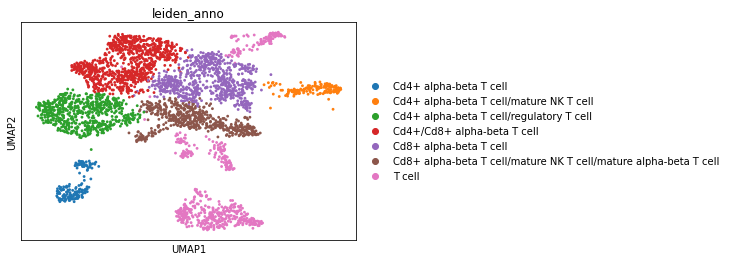

In [6]:
sc.pl.umap(dic_data_proc['facs'], color='leiden_anno')

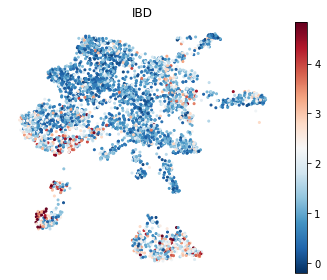

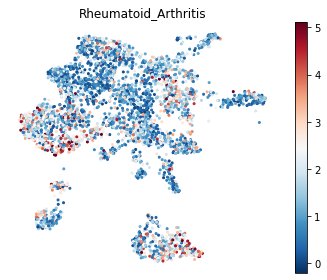

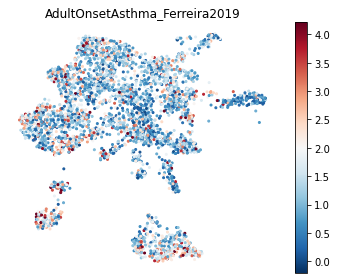

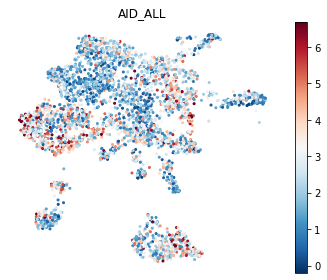

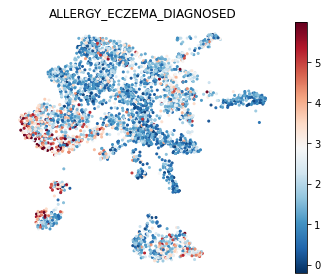

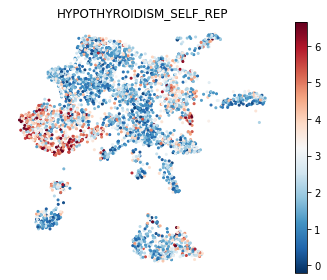

In [7]:
ds = 'facs'
for trait in TRAIT_LIST:
        
    plt.figure(figsize=[5,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')
    df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                           data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                                 'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1], 
                                 'leiden_anno':dic_data_proc[ds].obs['leiden_anno']})
    df_plot = df_plot.loc[dic_cell_list[ds]]
    df_plot = df_plot.join(dic_score[ds][['%s.fdr'%trait, '%s.nlog10_pval'%trait]])

    ind_select = df_plot['%s.fdr'%trait]<0.2
    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot['%s.nlog10_pval'%trait],
                cmap='RdBu_r', vmax=np.quantile(df_plot['%s.nlog10_pval'%trait], 0.99), vmin=-0.2, s=4)
    plt.colorbar()
    plt.title(trait.replace('PASS_','').replace('UKB_460K.disease_','').replace('UKB_460K.blood_',''))

    plt.tight_layout()
#     plt.savefig(FIG_PATH+'/trait_signal.%s.%s.png'%(trait, ds))
#     plt.savefig(FIG_PATH+'/trait_signal.%s.%s.svg'%(trait, ds))
    plt.show()
#     break

### PASS_IBD

... storing 'leiden_sig' as categorical


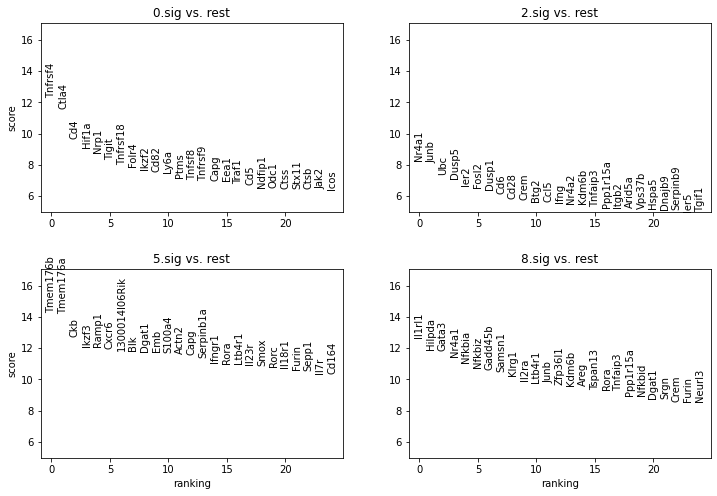

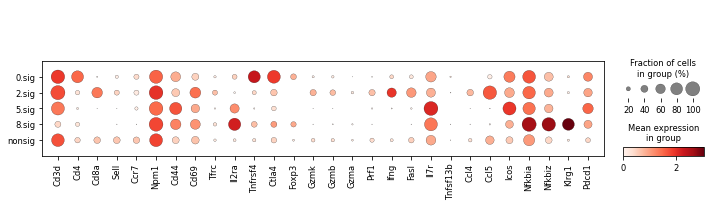

In [8]:
# IBD 
trait = 'PASS_IBD'
ds = 'facs'
adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
adata.obs = adata.obs.join(dic_score[ds]['%s.fdr'%trait])
adata.obs['leiden_sig'] = ['%s.sig'%x if y<0.2 else 'nonsig'
                           for x,y in zip(adata.obs['leiden'], adata.obs['%s.fdr'%trait])]

temp_df = adata.obs.groupby(['leiden_sig']).agg({'cell':len})
cluster_remove_list = list(temp_df.index[temp_df['cell']<25])
adata.obs.loc[adata.obs['leiden_sig'].isin(cluster_remove_list), 'leiden_sig'] = 'nonsig'

group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
sc.tl.rank_genes_groups(adata, groupby='leiden_sig', groups=group_list, method='wilcoxon')
sc.pl.rank_genes_groups(adata, fontsize=10, ncols=2, n_genes=25)

# temp_df = adata.obs.groupby(['leiden_sig', 'cell_ontology_class']).agg({'cell':len})
# display(temp_df.loc[temp_df['cell']>10])

# dot plot 
marker_list = ['Cd3d', 'Cd4', 'Cd8a', # Basic
               'Sell', 'Ccr7', 'Npm1', 'Cd44', # Naive Cd44-               
               'Cd69', 'Tfrc', 'Il2ra', 'Tnfrsf4', # Activation: Cd69, Cd71, Cd25 (also Treg)
               'Ctla4', 'Foxp3', # Treg
               'Gzmk', 'Gzmb', 'Gzma', 'Prf1', 'Ifng', 'Fasl', # Cd8+ cytotoxic T cells
               'Il7r', 'Tnfsf13b', 'Ccl4', 'Ccl5', # effector memory
               'Icos', 'Nfkbia', 'Nfkbiz', 'Klrg1', 'Pdcd1', # Others
              ]
sc.pl.dotplot(adata, marker_list, groupby='leiden_sig')

In [9]:
np.where(np.array([x[1] for x in adata.uns['rank_genes_groups']['names']])=='Gzmk')

(array([251]),)

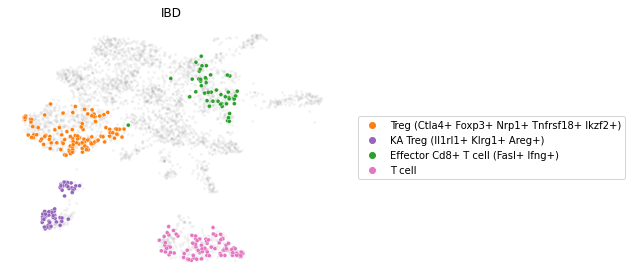

In [10]:
# UMAP plot with annotations 
dic_annot = {'0.sig': 'Treg (Ctla4+ Foxp3+ Nrp1+ Tnfrsf18+ Ikzf2+)', 
             # Ctla4 (Treg), Nrp1 (Treg), Tnfrsf18 (Treg), Ikzf2 (helios, Treg), Tnfrsf4 (OX40, effector)
             '2.sig': 'Effector Cd8+ T cell (Fasl+ Ifng+)', 
             # Fasl (CD8+ cytotoxic T), Ifng (CD8+ cytotoxic T), Ccl5 (HIV-suppressive factor)
             '5.sig': 'T cell', 
             # Cd4- Cd8-, may not be typical T cells
             '8.sig': 'KA Treg (Il1rl1+ Klrg1+ Areg+)'
             # Li_CR_2019 (Todo) Gata 3 (Th2)
            }
adata.obs['leiden_sig_anno'] = [dic_annot[x] if x in dic_annot else 'na' for x in adata.obs['leiden_sig']]
# adata.obs['leiden_sig_anno'] = adata.obs['leiden_sig_anno'].astype('category')

# Figure 
dic_config = {'Treg (Ctla4+ Foxp3+ Nrp1+ Tnfrsf18+ Ikzf2+)': ['C1'], 
              'KA Treg (Il1rl1+ Klrg1+ Areg+)': ['C4'],
              'Effector Cd8+ T cell (Fasl+ Ifng+)': ['C2'], 
              'T cell': ['C6']}
df_plot = pd.DataFrame(index=adata.obs_names,
                       data={'UMAP1':adata.obsm['X_umap'][:,0],
                             'UMAP2':adata.obsm['X_umap'][:,1]})
df_plot = df_plot.join(adata.obs['leiden_sig_anno'])

plt.figure(figsize=[9,4])
ax = plt.subplot(1,1,1)
ax.axis('off')
sns.scatterplot(data=df_plot.loc[df_plot['leiden_sig_anno']=='na'],
                x='UMAP1', y='UMAP2', color='k', s=8, alpha=0.05)
g = sns.scatterplot(data=df_plot.loc[df_plot['leiden_sig_anno']!='na'],
                    x='UMAP1', y='UMAP2', hue='leiden_sig_anno', s=16, 
                    hue_order = dic_config.keys(),
                    palette=[dic_config[x][0] for x in dic_config.keys()])
g.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
plt.title(DIC_TRAIT_NAME[trait])
plt.tight_layout()
# plt.savefig(FIG_PATH+'/IBD_umap.svg')
# plt.savefig(FIG_PATH+'/IBD_umap.png')
plt.show()

In [11]:
# Genes driving each part 
df_gs_gwas = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gs_file/gwas_max_abs_z.top500.gs',
                         sep='\t', index_col=0)
df_hom = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'
                     'mouse_human_homologs.txt', sep='\t')
dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
gwas_gene_list = [dic_map[x] for x in df_gs_gwas.loc[trait, 'GENESET'].split(',') if x in dic_map]
df_contrib = md.compute_gene_contrib(adata, gwas_gene_list)

df_contrib_stats = pd.DataFrame(index=df_contrib.columns, columns=group_list, data=0)
for group in group_list:
    cell_list = list(adata.obs_names[adata.obs['leiden_sig']==group])
    temp_df_sig = df_contrib.loc[cell_list].copy()
    temp_df_rest = df_contrib.loc[~df_contrib.index.isin(cell_list)]
    df_contrib_stats[group] = [sp.stats.ttest_ind(temp_df_sig[x].values, temp_df_rest[x].values)[0]
                               for x in df_contrib.columns]

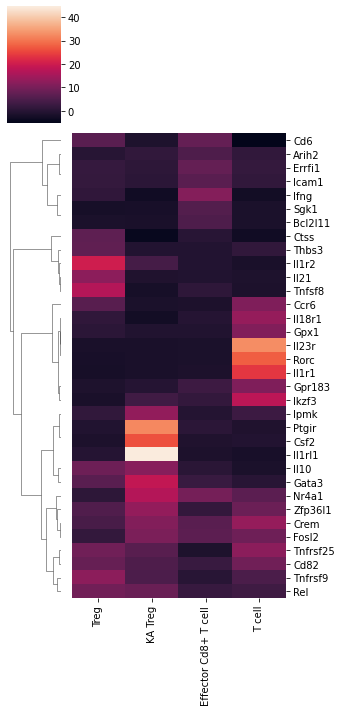

In [12]:
gene_list = []
for group in df_contrib_stats.columns:
    gene_list.extend(df_contrib_stats.sort_values(by=group, ascending=False).index[:10])
gene_list = list(set(gene_list))
df_plot = df_contrib_stats.loc[gene_list]
# df_plot = df_contrib_stats
df_plot = df_plot[['0.sig', '8.sig', '2.sig', '5.sig']]
df_plot.columns = [dic_annot[x].split('(')[0].strip() for x in df_plot.columns]

sns.clustermap(df_plot, metric='cosine', col_cluster=False, figsize=(5,10), cbar_pos=(0, 0.9, 0.05, 0.06))
plt.tight_layout()
# plt.savefig(FIG_PATH+'/IBD_trs_contrib_gene.svg')
plt.show()

In [13]:
# Overlapping of signatures 
df_sig = pd.DataFrame()
temp_df = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gs_file/tcell_signature.gs', 
                      sep='\t', index_col=0)
df_sig = temp_df.loc[['reg_cd4', 'effector_cd8']].copy()
for gs in df_sig.index:
    df_sig.loc[gs, 'GENESET'] = set([dic_map[x] for x in df_sig.loc[gs, 'GENESET'].split(',') if x in dic_map])
temp_df = pd.read_excel('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation'
                        '/Li_CR_2019_tabs2.xlsx', sheet_name='Treg Pagoda modules', skiprows=1)
df_sig.loc['KA_Treg', 'GENESET'] = set(temp_df['Module 12']) | set(temp_df['Module 21'])

background_set = set(adata.var_names)

df_stats = pd.DataFrame(index=df_sig.index, columns=group_list, data=0)
for sig in df_sig.index:
    gs_sig = df_sig.loc[sig, 'GENESET']
    for group in group_list:
        df_gene = sc.get.rank_genes_groups_df(adata, group=group)
        gs = set(df_gene['names'][:25])
        pvalue,oddsratio,or_ub,or_lb = util.test_overlap(gs, gs_sig, background_set)
        df_stats.loc[sig, group] = pvalue
        print('%s    %s    overlap=%d    p=%0.1e'%(sig, group, len(gs & gs_sig), pvalue), gs & gs_sig)
        
print(df_stats)

reg_cd4    0.sig    overlap=1    p=1.9e-01 {'Traf1'}
reg_cd4    2.sig    overlap=0    p=1.0e+00 set()
reg_cd4    5.sig    overlap=2    p=1.8e-02 {'Ramp1', 'Serpinb1a'}
reg_cd4    8.sig    overlap=2    p=1.8e-02 {'Gadd45b', 'Il2ra'}
effector_cd8    0.sig    overlap=1    p=1.9e-01 {'Tnfrsf9'}
effector_cd8    2.sig    overlap=2    p=1.8e-02 {'Ifng', 'Serpinb9'}
effector_cd8    5.sig    overlap=1    p=1.9e-01 {'S100a4'}
effector_cd8    8.sig    overlap=0    p=1.0e+00 set()
KA_Treg    0.sig    overlap=7    p=4.5e-10 {'Tnfrsf9', 'Tnfrsf18', 'Stx11', 'Ikzf2', 'Tigit', 'Odc1', 'Tnfrsf4'}
KA_Treg    2.sig    overlap=7    p=4.5e-10 {'Tnfaip3', 'Dusp1', 'Junb', 'Nr4a1', 'Fosl2', 'Tgif1', 'Kdm6b'}
KA_Treg    5.sig    overlap=0    p=1.0e+00 set()
KA_Treg    8.sig    overlap=13    p=4.5e-22 {'Tnfaip3', 'Klrg1', 'Nfkbid', 'Areg', 'Junb', 'Nr4a1', 'Zfp36l1', 'Gadd45b', 'Kdm6b', 'Il1rl1', 'Gata3', 'Nfkbiz', 'Nfkbia'}
                     0.sig         2.sig     5.sig         8.sig
TRAIT                

In [29]:
# Pathway 
dic_pathway = {}
group_list = list(adata.uns['rank_genes_groups']['names'].dtype.names)
pw_list = []
for group in group_list:
    df_gene = sc.get.rank_genes_groups_df(adata, group=group)
    gp = GProfiler(return_dataframe=True)
    df_pathway = gp.profile(organism=DIC_INFO[ds]['species'], 
                            query=list(df_gene['names'][:100]),
                            sources=['KEGG', 'GO:BP', 'REAC'],
                            significance_threshold_method='fdr', 
                            user_threshold=0.01,
                            background=list(adata.var_names)
                           )
    dic_pathway[group] = df_pathway.copy()
    ind_select = (df_pathway['term_size']<500) & (df_pathway['term_size']>5) & \
                    (df_pathway['intersection_size']>15)
    pw_list.extend(df_pathway.loc[ind_select, 'name'])
    break

for group in group_list:
    dic_pathway[group].index = dic_pathway[group]['name']
    dic_pathway[group] = dic_pathway[group].loc[set(dic_pathway[group].index) & set(pw_list)]

KeyError: '2.sig'

In [28]:
len(list(adata.var_names))

11739

In [30]:
df_pathway

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,KEGG,KEGG:05235,PD-L1 expression and PD-1 checkpoint pathway i...,7.778608e-08,True,PD-L1 expression and PD-1 checkpoint pathway i...,88,63,10,8787,0.158730,0.113636,query_1,[KEGG:00000]
1,KEGG,KEGG:04514,Cell adhesion molecules,1.169530e-07,True,Cell adhesion molecules,165,63,12,8787,0.190476,0.072727,query_1,[KEGG:00000]
2,REAC,REAC:R-MMU-168256,Immune System,4.323323e-06,True,Immune System,1637,49,27,8631,0.551020,0.016494,query_1,[REAC:0000000]
3,KEGG,KEGG:04659,Th17 cell differentiation,3.203581e-05,True,Th17 cell differentiation,103,63,8,8787,0.126984,0.077670,query_1,[KEGG:00000]
4,KEGG,KEGG:04612,Antigen processing and presentation,6.733159e-05,True,Antigen processing and presentation,82,63,7,8787,0.111111,0.085366,query_1,[KEGG:00000]
5,KEGG,KEGG:05167,Kaposi sarcoma-associated herpesvirus infection,7.565103e-05,True,Kaposi sarcoma-associated herpesvirus infection,218,63,10,8787,0.158730,0.045872,query_1,[KEGG:00000]
6,KEGG,KEGG:04658,Th1 and Th2 cell differentiation,7.565103e-05,True,Th1 and Th2 cell differentiation,87,63,7,8787,0.111111,0.080460,query_1,[KEGG:00000]
7,GO:BP,GO:0002376,immune system process,1.588594e-04,True,"""Any process involved in the development or fu...",331,60,11,11240,0.183333,0.033233,query_1,[GO:0008150]
8,GO:BP,GO:0002694,regulation of leukocyte activation,1.588594e-04,True,"""Any process that modulates the frequency, rat...",18,60,4,11240,0.066667,0.222222,query_1,"[GO:0002682, GO:0045321, GO:0050865]"
9,GO:BP,GO:0051249,regulation of lymphocyte activation,1.588594e-04,True,"""Any process that modulates the frequency, rat...",16,60,4,11240,0.066667,0.250000,query_1,"[GO:0002694, GO:0046649]"


ValueError: The number of observations cannot be determined on an empty distance matrix.

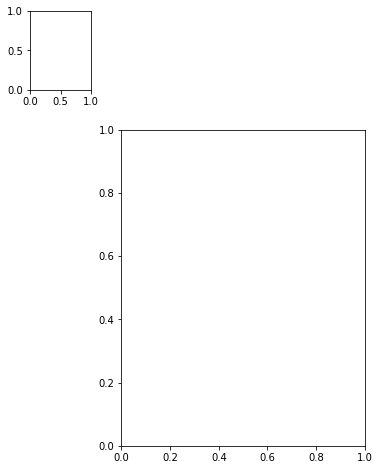

In [18]:
df_plot = pd.DataFrame()
for group in group_list:
    temp_df = dic_pathway[group][['p_value']]
    temp_df.index = ['%s:%s'%(x,y) for x,y in zip(dic_pathway[group]['source'], dic_pathway[group]['name'])]
    temp_df.columns = [group]
    df_plot = df_plot.join(temp_df, how='outer')
    
df_plot.fillna(1, inplace=True)
df_plot = -np.log10(df_plot)
df_plot = df_plot[['0.sig', '8.sig', '2.sig', '5.sig']]
df_plot.index.name = ''
df_plot.columns = [dic_annot[x].split('(')[0].strip() for x in df_plot.columns]

sns.clustermap(df_plot, col_cluster=False, figsize=(6,8), cbar_pos=(0, 0.85, 0.05, 0.18))
# plt.xticks(np.arange(4), df_plot.columns.values, rotation=45, ha='right')
plt.tight_layout()
# plt.savefig(FIG_PATH+'/IBD_pathway.svg')
plt.show()

In [97]:
# Is the selection in each cluster random? 
df_stats = pd.DataFrame(index=dic_annot.keys(), columns=['C', 'pval'], dtype=float)
n_ctrl = 500 
for cluster in dic_annot: 
    print(cluster)
    cluster_leiden = cluster.split('.')[0]
    temp_adata = dic_data_proc['facs'][dic_data_proc['facs'].obs['leiden']==cluster_leiden,:].copy()
    temp_df = dic_ctrl_score['facs'][trait].loc[temp_adata.obs_names].copy()
    c_ = util.gearys_c(temp_adata, dic_score['facs'].loc[temp_adata.obs_names, '%s.norm_score'%trait])
    v_c_ctrl = np.zeros(n_ctrl)
    for i_ctrl in range(n_ctrl):
        v_c_ctrl[i_ctrl] = util.gearys_c(temp_adata, temp_df['ctrl_norm_score_%d'%i_ctrl])
    df_stats.loc[cluster] = [c_, (np.sum(c_>=v_c_ctrl)+1)/(n_ctrl+1)]
display(df_stats)

0.sig
2.sig
5.sig
8.sig


,C,pval
0.sig,0.793159,0.001996
2.sig,0.868162,0.031936
5.sig,0.778055,0.013972
8.sig,0.732051,0.013972


0.sig


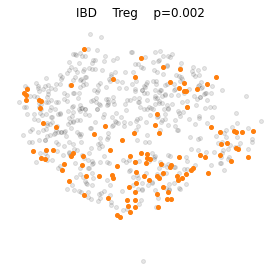

... storing 'leiden_sig_anno' as categorical


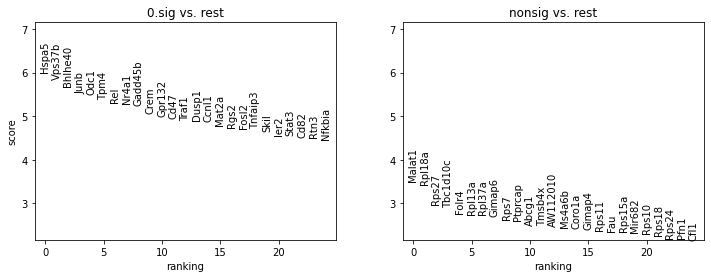

... storing 'leiden_sig_anno' as categorical
... storing 'leiden_vs_rest' as categorical


2.sig


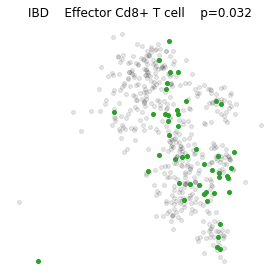

... storing 'leiden_sig_anno' as categorical


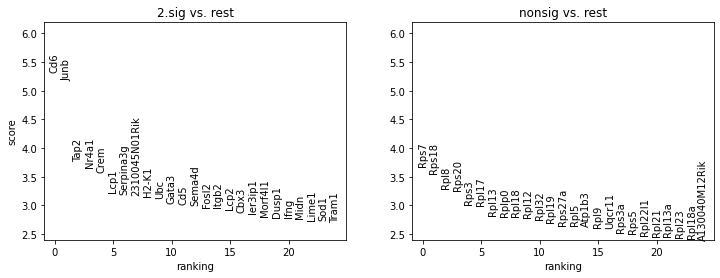

... storing 'leiden_sig_anno' as categorical
... storing 'leiden_vs_rest' as categorical


5.sig


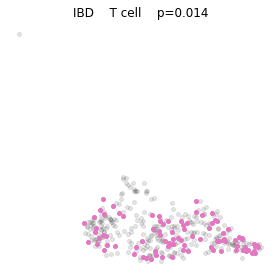

... storing 'leiden_sig_anno' as categorical


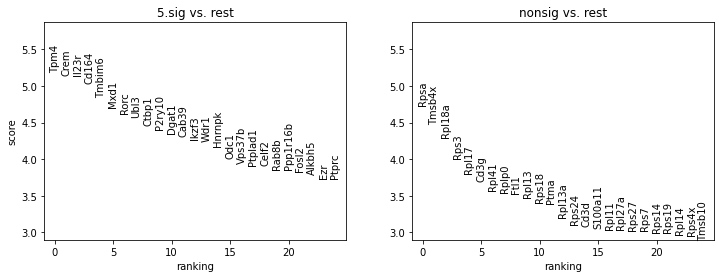

... storing 'leiden_sig_anno' as categorical
... storing 'leiden_vs_rest' as categorical


8.sig


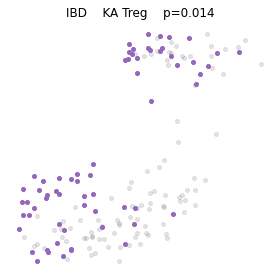

... storing 'leiden_sig_anno' as categorical


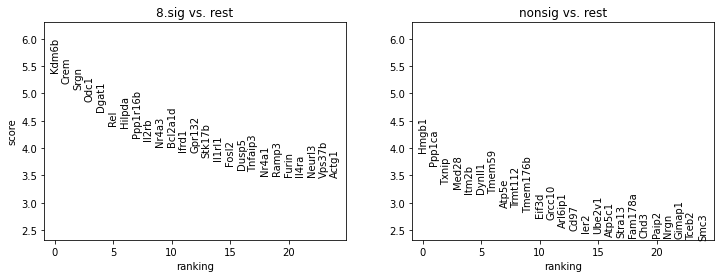

... storing 'leiden_sig_anno' as categorical
... storing 'leiden_vs_rest' as categorical


In [112]:
# Per cluster visualization/analysis 
dic_gs = {}
for cluster in dic_annot: 
    print(cluster)
    cluster_leiden = cluster.split('.')[0]
    temp_adata = adata[adata.obs['leiden']==cluster_leiden,:].copy()
    
    # Figure 
    df_plot = pd.DataFrame(index=temp_adata.obs_names,
                           data={'UMAP1':temp_adata.obsm['X_umap'][:,0],
                                 'UMAP2':temp_adata.obsm['X_umap'][:,1]})
    df_plot = df_plot.join(temp_adata.obs['leiden_sig_anno'])

    plt.figure(figsize=[4,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')
    ind_select = df_plot['leiden_sig_anno']!='na'
    plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                c='k', alpha=0.1, s=16)
    plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
                c=dic_config[df_plot.loc[ind_select, 'leiden_sig_anno'][0]][0],
                cmap='Reds', vmax=1.1, vmin=-0.1, s=16)
    plt.title(DIC_TRAIT_NAME[trait]+'    '+dic_annot[cluster].split(' (')[0]+
              '    p=%0.3f'%df_stats.loc[cluster, 'pval'])
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/IBD_umap.%s.svg'%cluster_leiden)
    plt.savefig(FIG_PATH+'/IBD_umap.%s.png'%cluster_leiden)
    plt.show()
    
    # SEGs
    sc.tl.rank_genes_groups(temp_adata, groupby='leiden_sig', method='wilcoxon')
    sc.pl.rank_genes_groups(temp_adata, fontsize=10, ncols=2, n_genes=25)
    
    df_gene = sc.get.rank_genes_groups_df(temp_adata, group=cluster)
    dic_gs[cluster] = list(df_gene['names'][:100])
    df_gene = sc.get.rank_genes_groups_df(temp_adata, group='nonsig')
    dic_gs[cluster.replace('.sig', '.nonsig')] = list(df_gene['names'][:100])
    
    # sig and nonsig as compared to the rest
    cell_list_sig = temp_adata.obs_names[temp_adata.obs['leiden_sig']==cluster]
    cell_list_nonsig = temp_adata.obs_names[temp_adata.obs['leiden_sig']=='nonsig']
    temp_adata = adata.copy()
    temp_adata.obs['leiden_vs_rest'] = 'rest'
    temp_adata.obs.loc[cell_list_sig, 'leiden_vs_rest'] = 'sig'
    temp_adata.obs.loc[cell_list_nonsig, 'leiden_vs_rest'] = 'nonsig'
    sc.tl.rank_genes_groups(temp_adata, groupby='leiden_vs_rest', groups=['sig', 'nonsig'], method='wilcoxon')
    df_gene = sc.get.rank_genes_groups_df(temp_adata, group='sig')
    dic_gs[cluster.replace('.sig', '.sig_vs_rest')] = list(df_gene['names'][:100])
    df_gene = sc.get.rank_genes_groups_df(temp_adata, group='nonsig')
    dic_gs[cluster.replace('.sig', '.nonsig_vs_rest')] = list(df_gene['names'][:100])

In [99]:
dic_pathway = {}
pw_list = []
for term in dic_gs:
    gp = GProfiler(return_dataframe=True)
    df_pathway = gp.profile(organism=DIC_INFO[ds]['species'], 
                            query=dic_gs[term],
                            sources=['KEGG', 'GO:BP', 'REAC'],
                            significance_threshold_method='fdr', 
                            user_threshold=0.01,
                            background=list(adata.var_names))
    dic_pathway[term] = df_pathway.copy()
    ind_select = (df_pathway['term_size']<500) & (df_pathway['term_size']>5) & \
                    (df_pathway['intersection_size']>15)
    pw_list.extend(df_pathway.loc[ind_select, 'name'])
pw_list = list(set(pw_list))

for term in dic_gs:
    dic_pathway[term].index = dic_pathway[term]['name']
    dic_pathway[term] = dic_pathway[term].loc[set(dic_pathway[term].index) & set(pw_list)]

0.sig


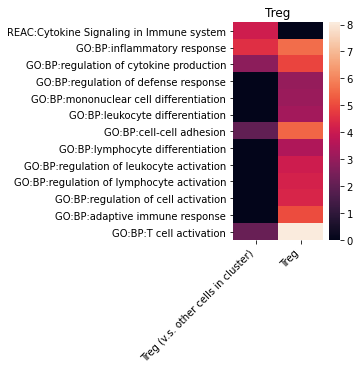

2.sig


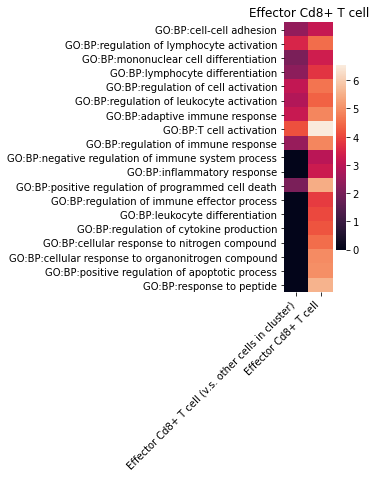

5.sig


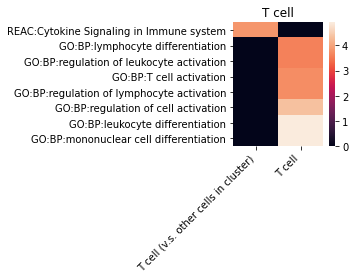

8.sig


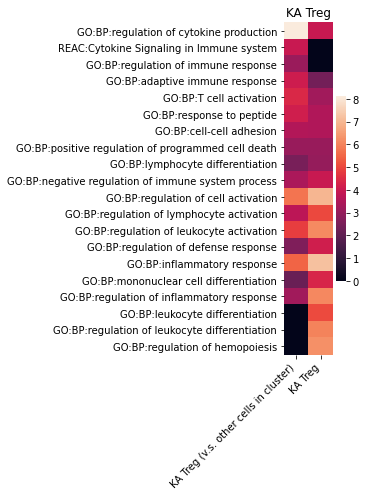

In [111]:
for cluster in dic_annot:
    print(cluster)
    df_plot = pd.DataFrame()
    for group in ['%s.sig_vs_rest'%cluster.split('.')[0], '%s.sig'%cluster.split('.')[0]]:
        temp_df = dic_pathway[group][['p_value']]
        temp_df.index = ['%s:%s'%(x,y) for x,y in zip(dic_pathway[group]['source'], dic_pathway[group]['name'])]
        temp_df.columns = [group]
        df_plot = df_plot.join(temp_df, how='outer')

    df_plot.fillna(1, inplace=True)
    df_plot = -np.log10(df_plot)
    df_plot = df_plot.loc[df_plot.max(axis=1)>3]
    df_plot.index.name = ''
    df_plot['dif'] = df_plot.iloc[:,0] - df_plot.iloc[:,1]
    df_plot.sort_values(by='dif', inplace=True)
    df_plot = df_plot[['%s.sig'%cluster.split('.')[0], '%s.sig_vs_rest'%cluster.split('.')[0]]]
    df_plot.columns = [dic_annot[cluster].split(' (')[0]+' (v.s. other cells in cluster)',
                       dic_annot[cluster].split(' (')[0]]
    
    plt.figure(figsize=[5, 2+0.25*df_plot.shape[0]])
    sns.heatmap(df_plot)
    plt.title(dic_annot[cluster].split(' (')[0])
    plt.xticks(np.arange(df_plot.shape[1])+0.5, df_plot.columns, rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/IBD_pathway.with_cluster_ref.%s.svg'%cluster)
    plt.show()
#     break

In [102]:
FIG_PATH

'/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/results/fig_tcell'

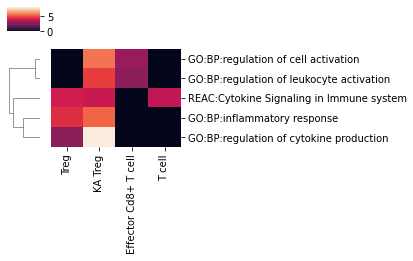

/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


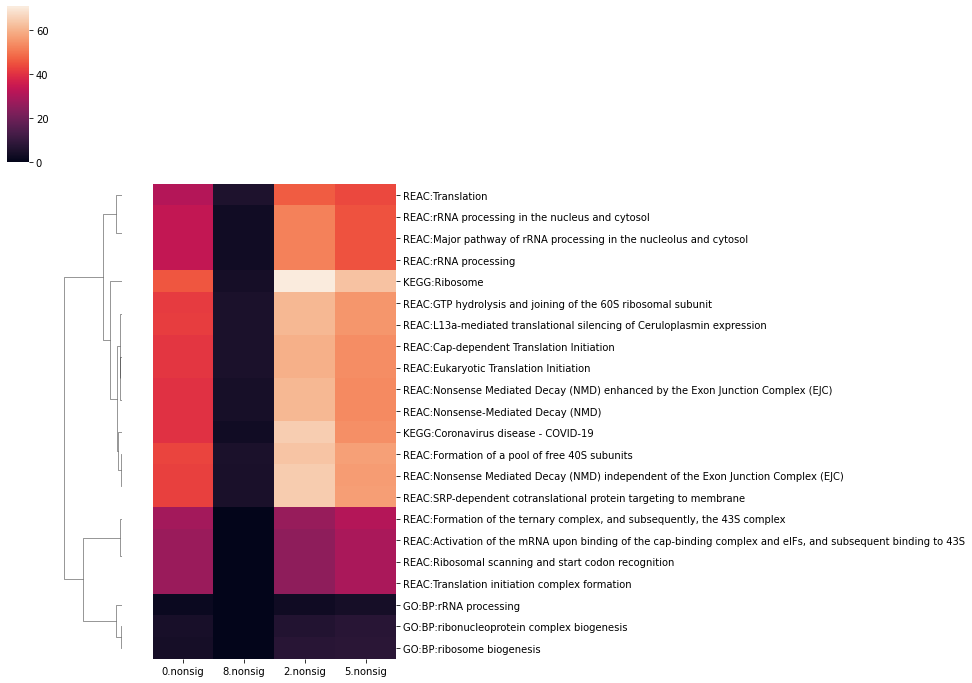

In [103]:
df_plot = pd.DataFrame()
for group in dic_gs:
    temp_df = dic_pathway[group][['p_value']]
    temp_df.index = ['%s:%s'%(x,y) for x,y in zip(dic_pathway[group]['source'], dic_pathway[group]['name'])]
    temp_df.columns = [group]
    df_plot = df_plot.join(temp_df, how='outer')
    
df_plot.fillna(1, inplace=True)
df_plot = -np.log10(df_plot)
df_plot = df_plot[['0.sig', '8.sig', '2.sig', '5.sig']]
df_plot = df_plot.loc[df_plot.mean(axis=1)>1]
df_plot.index.name = ''
df_plot.columns = [dic_annot[x].split('(')[0].strip() for x in df_plot.columns]

sns.clustermap(df_plot, col_cluster=False, figsize=(6,4), cbar_pos=(0, 0.85, 0.05, 0.18))
plt.tight_layout()
plt.savefig(FIG_PATH+'/IBD_pathway.percluster_sig_cell.svg')
plt.show()


df_plot = pd.DataFrame()
for group in dic_gs:
    temp_df = dic_pathway[group][['p_value']]
    temp_df.index = ['%s:%s'%(x,y) for x,y in zip(dic_pathway[group]['source'], dic_pathway[group]['name'])]
    temp_df.columns = [group]
    df_plot = df_plot.join(temp_df, how='outer')
    
df_plot.fillna(1, inplace=True)
df_plot = -np.log10(df_plot)
df_plot = df_plot[['0.nonsig', '8.nonsig', '2.nonsig', '5.nonsig']]
df_plot = df_plot.loc[df_plot.mean(axis=1)>2]
df_plot.index.name = ''

sns.clustermap(df_plot, col_cluster=False, figsize=(6,12), cbar_pos=(0, 0.7, 0.05, 0.18))
plt.tight_layout()
plt.savefig(FIG_PATH+'/IBD_pathway.percluster_nonsig_cell.svg')
plt.show()

### RA 

... storing 'annot_sig' as categorical


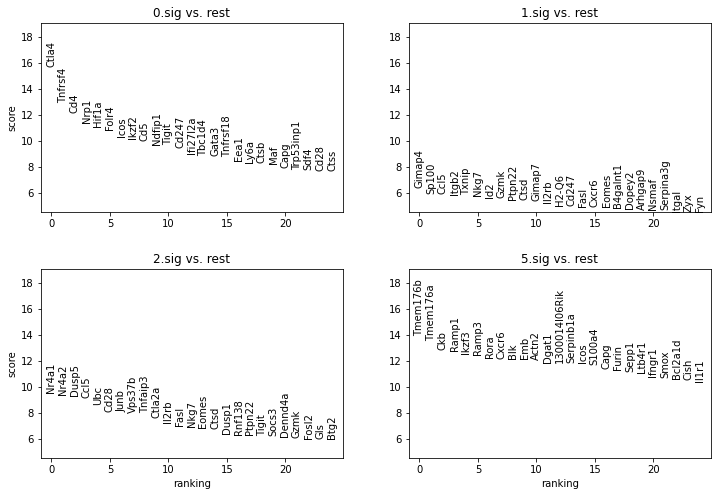

In [51]:
# IBD 
trait = 'PASS_Rheumatoid_Arthritis'
ds = 'facs'
adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
adata.obs = adata.obs.join(dic_score[ds]['%s.fdr'%trait])
adata.obs['annot_sig'] = ['%s.sig'%x if y<0.1 else 'nonsig'
                          for x,y in zip(adata.obs['leiden'], adata.obs['%s.fdr'%trait])]
temp_df = adata.obs.groupby(['annot_sig']).agg({'cell':len})
cluster_remove_list = list(temp_df.index[temp_df['cell']<50])
adata.obs.loc[adata.obs['annot_sig'].isin(cluster_remove_list), 'annot_sig'] = 'nonsig'

group_list = sorted([x for x in adata.obs['annot_sig'].unique() if '.sig' in x])
sc.tl.rank_genes_groups(adata, groupby='annot_sig', groups=group_list, method='wilcoxon')
sc.pl.rank_genes_groups(adata, fontsize=10, ncols=2, n_genes=25)

... storing 'annot_sig' as categorical


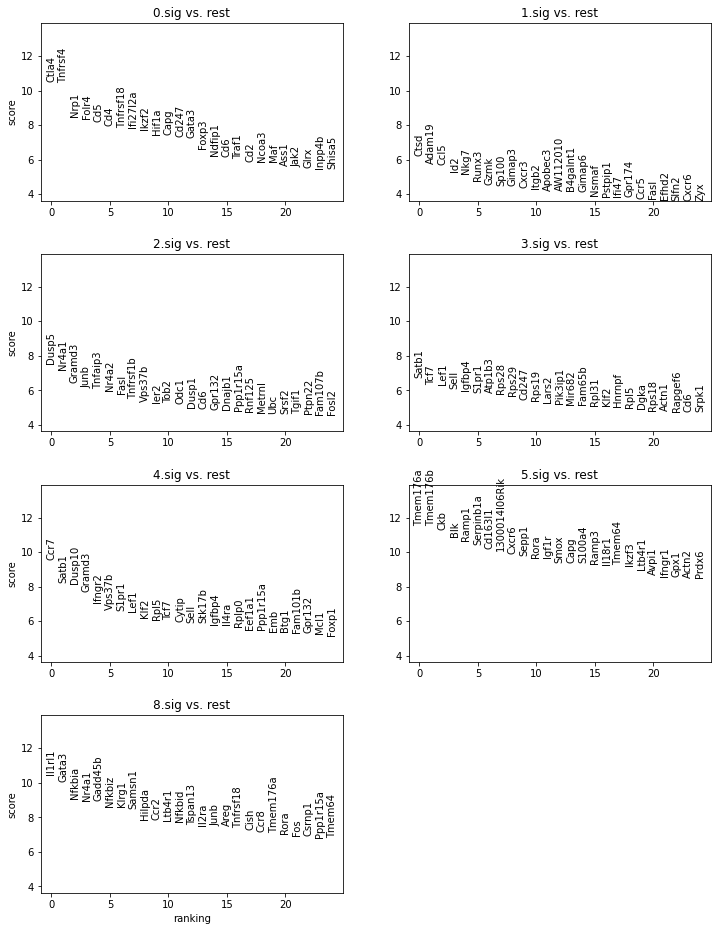

In [55]:
# Asthma
trait = 'PASS_AdultOnsetAsthma_Ferreira2019'
ds = 'facs'
adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
adata.obs = adata.obs.join(dic_score[ds]['%s.fdr'%trait])
adata.obs['annot_sig'] = ['%s.sig'%x if y<0.2 else 'nonsig'
                          for x,y in zip(adata.obs['leiden'], adata.obs['%s.fdr'%trait])]
temp_df = adata.obs.groupby(['annot_sig']).agg({'cell':len})
cluster_remove_list = list(temp_df.index[temp_df['cell']<25])
adata.obs.loc[adata.obs['annot_sig'].isin(cluster_remove_list), 'annot_sig'] = 'nonsig'

group_list = sorted([x for x in adata.obs['annot_sig'].unique() if '.sig' in x])
sc.tl.rank_genes_groups(adata, groupby='annot_sig', groups=group_list, method='wilcoxon')
sc.pl.rank_genes_groups(adata, fontsize=10, ncols=2, n_genes=25)

In [53]:
group_list

[]

In [29]:
TRAIT_LIST

['PASS_IBD',
 'PASS_Rheumatoid_Arthritis',
 'PASS_AdultOnsetAsthma_Ferreira2019',
 'UKB_460K.disease_AID_ALL',
 'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED',
 'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP']

### Prioritize gene sets 